In [26]:
import numpy as np
from matplotlib import pyplot as plt

import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jr
import optax  # https://github.com/deepmind/optax
import torch  # https://pytorch.org
import torchvision  # https://pytorch.org
from jaxtyping import Array, Float, Int, PyTree  # https://github.com/google/jaxtyping

In [27]:
from nn import Module, Network

In [28]:
# Hyperparameters

BATCH_SIZE = 1
LEARNING_RATE = 1e-3
STEPS = 10000
PRINT_EVERY = 1000
SEED = 1234

In [29]:
normalise_data = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,), (0.5,)),
    ]
)
train_dataset = torchvision.datasets.MNIST(
    "MNIST",
    train=True,
    download=True,
    transform=normalise_data,
)
test_dataset = torchvision.datasets.MNIST(
    "MNIST",
    train=False,
    download=True,
    transform=normalise_data,
)
trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True
)

In [30]:
layer1 = Module(
    eqx.nn.Linear(
        in_features=28*28,
        out_features=500,
        key=jr.PRNGKey(SEED)
    )
)
layer2 = Module(
    eqx.nn.Linear(
        in_features=500,
        out_features=500,
        key=jr.PRNGKey(SEED)
    )
)
# layer3 = Module(
#     eqx.nn.Linear(
#         in_features=500,
#         out_features=10,
#         key=jr.PRNGKey(SEED)
#     )
# )

model = Network(
    # [layer1, layer2, layer3],
    [layer1, layer2],
    optax.adam(LEARNING_RATE)
)

print(model)

Network(
goodness: 0.0,
trainable layers: [0, 1],
optimizer: GradientTransformationExtraArgs(init=<function chain.<locals>.init_fn at 0x7f8e7f924860>, update=<function chain.<locals>.update_fn at 0x7f8d9f69e8e0>),
Layer 0: Module(
  _layer=Linear(
    weight=f32[500,784],
    bias=f32[500],
    in_features=784,
    out_features=500,
    use_bias=True
  ),
  _activation=<function <lambda>>,
  _goodness_fn=<function <lambda>>,
  _opt_state=None,
  _theta=2.0
),
Layer 1: Module(
  _layer=Linear(
    weight=f32[500,500],
    bias=f32[500],
    in_features=500,
    out_features=500,
    use_bias=True
  ),
  _activation=<function <lambda>>,
  _goodness_fn=<function <lambda>>,
  _opt_state=None,
  _theta=2.0
),
)


In [31]:
dummy_x, dummy_y = next(iter(trainloader))
dummy_x = dummy_x.numpy()
dummy_y = dummy_y.numpy()
print(dummy_x.shape)  # BATCH_SIZEx1x28x28
print(dummy_y.shape)  # BATCH_SIZE

(1, 1, 28, 28)
(1,)


In [32]:
def overlay_y_on_x(x: Array, y: Array):
    """
    Replace the first 10 pixels of data [x] with one-hot-encoded label [y]
    """
    x_ = jnp.ravel(x)
    x_ = x_.at[:10].set(jax.nn.one_hot(y, 10).squeeze())

    return x_.reshape(x.shape)

if BATCH_SIZE > 1:
    overlay_y_on_x = eqx.filter_vmap(overlay_y_on_x)

In [33]:
def permute_label(n: Int, y: Array):
    """
    Permute the labels of the data [y]
    """
    if isinstance(y, int):
        # For single label, return a random value different from y
        return (y + jr.randint(jr.PRNGKey(n), (), 1, 10)) % 10
    else:
        # For batch of labels, return random values different from each label
        key = jr.PRNGKey(n)
        offsets = jr.randint(key, shape=y.shape, minval=1, maxval=10)
        return (y + offsets) % 10

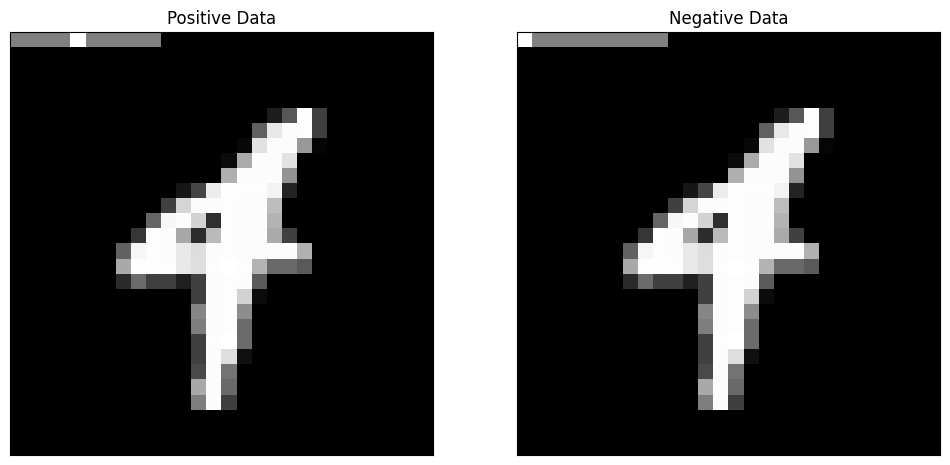

In [34]:
dummy_x_p = overlay_y_on_x(np.squeeze(dummy_x), dummy_y)
dummy_x_n = overlay_y_on_x(np.squeeze(dummy_x), permute_label(10, dummy_y))

if BATCH_SIZE > 1:
    show = (dummy_x_p[0], dummy_x_n[0])
else:
    show = (dummy_x_p, dummy_x_n)

ax = plt.subplot(1, 2, 1)
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(show[0], cmap='gray')
ax.set_title("Positive Data")
ax = plt.subplot(1, 2, 2)
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(show[1], cmap='gray')
ax.set_title("Negative Data")
plt.gcf().set_size_inches(12, 6)
plt.show()

In [35]:
# train the first layer

losses = []
positive_gs = []
negative_gs = []

for i in range(STEPS):
    x, y = next(iter(trainloader))
    x = x.numpy()
    y = y.numpy()

    x_p = overlay_y_on_x(np.squeeze(x), y)
    x_n = overlay_y_on_x(np.squeeze(x), permute_label(10, y))

    if BATCH_SIZE > 1:
        x_p = jax.vmap(jnp.ravel)(x_p)
        x_n = jax.vmap(jnp.ravel)(x_n)
    else:
        x_p = jnp.ravel(x_p)
        x_n = jnp.ravel(x_n)

    loss, g_pos, g_neg = model.train_layer(
        0,
        x_p,
        x_n,
        batch = BATCH_SIZE > 1,
        batch_index=0
    )

    losses.append(loss)
    positive_gs.append(g_pos)
    negative_gs.append(g_neg)

    if i % PRINT_EVERY == 0:
        print(f"Step {i}: loss={loss:.4f}")

Step 0: loss=1.1268
Step 1000: loss=0.6934
Step 2000: loss=0.6949
Step 3000: loss=0.6902
Step 4000: loss=0.6889
Step 5000: loss=0.6971
Step 6000: loss=0.6941
Step 7000: loss=0.6947
Step 8000: loss=0.6925
Step 9000: loss=0.6875


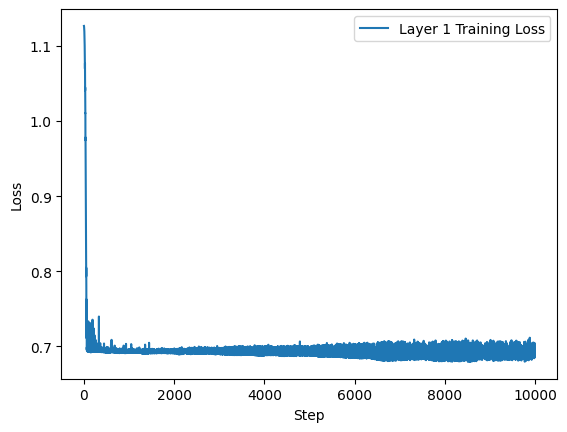

In [36]:
plt.plot(losses, label="Layer 1 Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [37]:
# train the second layer

losses_2 = []

for i in range(STEPS):
    x, y = next(iter(trainloader))
    x = x.numpy()
    y = y.numpy()

    x_p = overlay_y_on_x(np.squeeze(x), y)
    x_n = overlay_y_on_x(np.squeeze(x), permute_label(10, y))

    if BATCH_SIZE > 1:
        x_p = jax.vmap(jnp.ravel)(x_p)
        x_n = jax.vmap(jnp.ravel)(x_n)

        x_p = model.layers[0].forward(x_p)
        x_n = model.layers[0].forward(x_n)
    else:
        x_p = jnp.ravel(x_p)
        x_n = jnp.ravel(x_n)

        x_p = model.layers[0].forward(jnp.expand_dims(x_p, 0))
        x_n = model.layers[0].forward(jnp.expand_dims(x_n, 0))

        x_p = jnp.squeeze(x_p)
        x_n = jnp.squeeze(x_n)

    loss, g_pos, g_neg = model.train_layer(
        1,
        x_p,
        x_n,
        batch = BATCH_SIZE > 1,
        batch_index=0
    )

    losses_2.append(loss)

    if i % PRINT_EVERY == 0:
        print(f"Step {i}: loss={loss:.4f}")

Step 0: loss=1.1267
Step 1000: loss=0.6961
Step 2000: loss=0.7004
Step 3000: loss=0.6927
Step 4000: loss=0.6950
Step 5000: loss=0.6938
Step 6000: loss=0.6928
Step 7000: loss=0.6927
Step 8000: loss=0.6914
Step 9000: loss=0.6846


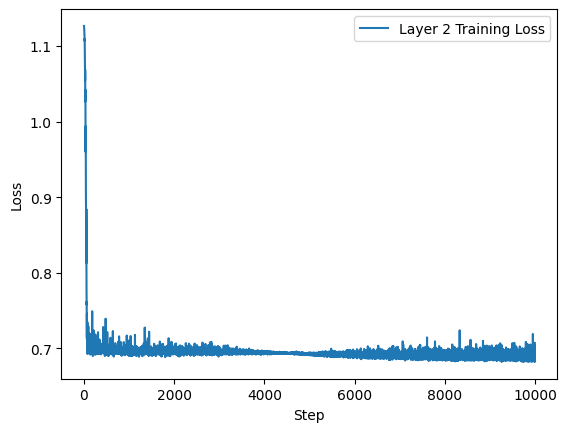

In [38]:
plt.plot(losses_2, label="Layer 2 Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [39]:
def predict(x: Array):
    goodness_per_label = []
    for label in range(10):
        x_ = overlay_y_on_x(x, np.array([label]))
        x_ = np.ravel(x_)
        x_ = np.expand_dims(x_, axis=0)
        goodness = 0.0
        for layer in model.layers:
            g = layer.goodness(x_)
            goodness += g
            x_ = layer.forward(x_)
        goodness_per_label.append(goodness.item())
    return np.argmax(goodness_per_label), goodness_per_label

Prediction: 0
Goodnesses: [4.093668460845947, 4.039516448974609, 4.071971893310547, 4.083555221557617, 4.006622791290283, 4.075437068939209, 4.00881290435791, 4.023899078369141, 4.042932510375977, 4.004727363586426]


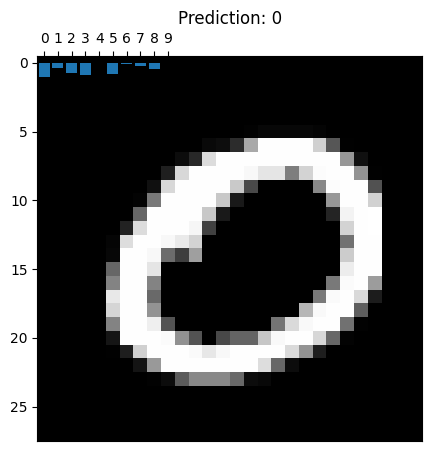

In [51]:
if BATCH_SIZE > 1:
    data = dummy_x[1]
else:
    data = dummy_x

prediction, goodnesses = predict(data)

print(f"Prediction: {prediction}")
print(f"Goodnesses: {goodnesses}")

# Normalize goodness values for better visualization
normalized_goodness = [(g - min(goodnesses)) / (max(goodnesses) - min(goodnesses)) for g in goodnesses]

plt.figure(figsize=(10, 5))
plt.bar(range(10), normalized_goodness)
plt.title('Goodness Score per Label')
plt.xticks(range(10))
plt.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
# plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.imshow(np.squeeze(data), cmap='gray')
plt.title(f"Prediction: {prediction}")
plt.show()

In [52]:
goodnesses: list[list[float]] = []

for i in range(len(dummy_x)):
    data = dummy_x[i]
    prediction, goodness = predict(data)
    goodnesses.append(goodness)

goodnesses = np.array(goodnesses)
print(goodnesses.shape)

(1, 10)


In [53]:
# Set numpy print options to display 100 columns and 3 decimal places
np.set_printoptions(linewidth=100, precision=3, suppress=True)

print(f"{"Goodnesses Vector".center(81)} | Predicted Label")
print("=" * 100)
for g in goodnesses:
    print(f"{g} | {np.argmax(g)} | {np.max(g):.3f} | {np.argmin(g)} | {np.min(g):.3f}")

                                Goodnesses Vector                                 | Predicted Label
[4.094 4.04  4.072 4.084 4.007 4.075 4.009 4.024 4.043 4.005] | 0 | 4.094 | 9 | 4.005


In [43]:
# predict on test set

correct = 0
total = 0

for i, (x, y) in enumerate(testloader):
    print(f"{i+1}/{len(testloader)} | Accuracy: {correct/(total+1):.4f}", end="\r")
    x = x.numpy()
    y = y.numpy()

    # print(x.shape)

    for i in range(len(x)):
        prediction, _ = predict(x[i])
        if prediction == y[i]:
            correct += 1
        total += 1

print(f"\nAccuracy: {correct/total:.4f}")

10000/10000 | Accuracy: 0.1958
Accuracy: 0.1958
